```
ME72: Maestría en Métodos Cuantitativos para la Gestión y Análisis de Datos
M72109: Analisis de datos no estructurados
Universidad de Buenos Aires - Facultad de Ciencias Economicas (UBA-FCE)
Año: 2020
Profesor: Facundo Santiago
```

# Introducción a Métodos basados en frecuencias y Topic Modeling

Topic modeling es una técnica de aprendizaje automático no supervisado donde intentados descubrir tópicos que son abstractos al texto pero que pueden describir una colección de documentos. Es importante marcar que estos "tópicos" no son necesariamente equivalentes a la interpretación coloquial de tópicos, sino que responden a un patrón que emerge de las palabras que están en los documentos.

La suposición básica para Topic Modeling es que cada documento está representado por una mescla de tópicos, y cada tópico consiste en una colección de palabras.

## Sobre el set de datos con el que vamos a trabajar

Utilizaremos como ejemplo un set de datos en español que contiene tweets que diferentes usuarios han publicado en relación a diferentes marcas de productos u empresas en el rubro de alimentación, construcción, automoviles, etc. Estos tweets, a su vez, están asociados a una de las diferentes fases en el proceso de ventas (también conocido como Marketing Funel) y por eso están tagueados con las fases de:
 - Awareness – el cliente es conciente de la existencia de un producto o servicio
 - Interest – activamente expresa el interes de un producto o servicio
 - Evaluation – aspira una marca o producto en particular
 - Purchase – toma el siguiente paso necesario para comprar el producto o servicio
 - Postpurchase - realización del proceso de compra. El cliente compara la diferencia entre lo que deseaba y lo que obtuvo

Referencia: Spanish Corpus of Tweets for Marketing [http://ceur-ws.org/Vol-2111/paper1.pdf]

Primero importaremos algunas librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Preparé una versión pre-procesada de este dataset que pueden descargar desde:

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/NLP/Datasets/mascorpus/tweets_marketing.csv --directory-prefix ./Datasets/mascorpus/

--2020-08-28 15:29:51--  https://raw.githubusercontent.com/santiagxf/M72109/master/NLP/Datasets/mascorpus/tweets_marketing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 512573 (501K) [text/plain]
Saving to: ‘./Datasets/mascorpus/tweets_marketing.csv.2’

tweets_marketing.cs 100%[===================>] 500.56K  --.-KB/s    in 0.08s   

2020-08-28 15:29:51 (6.06 MB/s) - ‘./Datasets/mascorpus/tweets_marketing.csv.2’ saved [512573/512573]



In [ ]:
tweets = pd.read_csv('Datasets/mascorpus/tweets_marketing.csv')

Inspeccionamos el set de datos

In [ ]:
tweets.head(5)

,TEXTO,SECTOR,MARCA,CANAL,AWARENESS,EVALUATION,PURCHASE,POSTPURCHASE,NC2
0,#tablondeanuncios Funda nordica ikea #madrid h...,RETAIL,IKEA,Microblog,0,0,0.0,0,1.0
1,#tr Me ofrezco para montar muebles de Ikea - H...,RETAIL,IKEA,Microblog,0,0,0.0,0,1.0
2,#VozPópuli Vozpópuli @voz_populi - #LoMásLeido...,RETAIL,ALCAMPO,Microblog,0,0,0.0,0,1.0
3,#ZonaTecno Destacado: Todo lo que hay que sabe...,RETAIL,CARREFOUR,Microblog,0,0,0.0,0,1.0
4,$Carrefour retira pez #Panga. OCU y grupos x #...,RETAIL,CARREFOUR,Microblog,0,0,0.0,0,1.0


In [ ]:
tweets.groupby('SECTOR').head(1)[['TEXTO', 'SECTOR']]

,TEXTO,SECTOR
0,#tablondeanuncios Funda nordica ikea #madrid h...,RETAIL
725,"""Ilcinsisti lis MB dispiniblis"" te odeeeeeo Mo...",TELCO
964,#CarlosSlim y Bimbo lanzarán un vehículo eléct...,ALIMENTACION
1298,"‼🏎Toyota #Day, 4ruedas ,1/4 milla, 1 #pasión, ...",AUTOMOCION
1748,"""- Tú qué.\n- Yo na.""\nConversaciones banco sa...",BANCA
2348,"- Cariño, te juro que sólo tenían Cruzcampo en...",BEBIDAS
3023,#adidas #hockey Amenabar 2080 CABA https://t.c...,DEPORTES


## Preprosesamiento

Como en toda tarea de NLP, y más generalmente, en Machine Learning, ocuparemos una porción de nuestro tiempo en preprocesar los datos para generar representaciones útiles y deshacernos de problemas especificos que podría exhibir nuestro set de datos. Veamos a continuación algunos:

### Stop words



Algunas palabras que son extremadamente frecuentes, "a-priori" (revisaremos este concepto luego) no son de mucha utilidad para resolver una tarea de clasificación de texto específica. Estas palabras se las conoce como Stop words y, dado que son de poca utilidad, son eliminadas del texto.

**Spoiler Alert:**
Mencionamos 'a priori', porque la tendencia general en los ultimos tiempos ha sido ir desde grandes listas de stop words en el order de 200-300 a listas muy pequeñas (10-15 - si es que las hay). Los buscadores, por ejemplo, hoy en día no eliminan estas palabras. Cuando veamos modelos de lenguaje, en realidad las vamos a necesitar.

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
spa_stopwords = stopwords.words('spanish')

In [ ]:
spa_stopwords[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

### Tokenización

Se refiere al proceso de generación de tokens basado en un texto. A alto nivel, se podría ver como la tarea de dividir oraciones en palabras. Un token se diferencia de una palabra en el hecho de que una palabra es una instancia de un token. Existen varias técnicas para separar una oración o texto en general en tokens:

Lectura recomendada: Diferentes tokenizers:
 - http://www.nltk.org/api/nltk.tokenize.html

Tomemos un tweet de ejemplo:

In [ ]:
tweet = tweets['TEXTO'][5]
print(tweet)

. @PoliciadeBurgos @PCivilBurgos @Aytoburgos Mismo peligro c/ Rio Viejo junto Mercadona Villimar


In [ ]:
from nltk.tokenize.treebank import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

In [ ]:
tokenizer.tokenize(tweet)

['.',
 '@',
 'PoliciadeBurgos',
 '@',
 'PCivilBurgos',
 '@',
 'Aytoburgos',
 'Mismo',
 'peligro',
 'c/',
 'Rio',
 'Viejo',
 'junto',
 'Mercadona',
 'Villimar']

In [ ]:
from nltk.tokenize.casual import TweetTokenizer

tokenizer = TweetTokenizer()

In [ ]:
tokenizer.tokenize(tweet)

['.',
 '@PoliciadeBurgos',
 '@PCivilBurgos',
 '@Aytoburgos',
 'Mismo',
 'peligro',
 'c',
 '/',
 'Rio',
 'Viejo',
 'junto',
 'Mercadona',
 'Villimar']

### Stemming and Lemmatization

Existen palabras cuyo significado no cambia ya que estan atados a una palabra raiz que les da el significado:

<i>Organizan, organiza, organizando, organizaron</i>

**Stemming y Lemmatization** son dos técnicas que generan la palabra raiz dada una palabra. La diferencia que hay entre estas técnicas es que **Lemmatization** utiliza reglas del lenguaje para extraer las palabras raiz y por lo tanto, el resultado son palabras que existen en el vocabulario. Por el contrario, **Stemming** utiliza heuristicas que truncan la palabra hasta su raiz invariable. El resultado son "psudopalabras" o mejor conocidos como tokens que no forman una palabra del lenguaje propiamente dicho. Esta técnica, como se puede intuir, es más rápida computacionalmente. 

Utilizaremos la libreria nltk para stemming y spaCy para lemmatization

In [ ]:
from nltk import stem

import spacy
from spacy.lemmatizer import Lemmatizer

In [ ]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


**Sobre la libreria spaCy:** Spacy es una libreria para NLP muy polupar actualmente ya que, al contrario de nltk, ofrece formas muy eficientes de hacer solo algunos tipos de operaciones. NLTK es una herramienta más general. Para instalar spaCy en español necesitaran ejecutar:

```
conda install -c spacy spacy
python -m spacy download es_core_news_sm
```

Si bien NLTK ofrece la opción de hacer Lemmatization, su soporte mayoritariamente es para ingles. La versión en español no es demasiado buena. Si les interesa probarla puede hacerlo a traves del metodo.

```
nltk.wordnet.lemas("palabra", lang='spa')
```

Cargamos el modelo en español e instanciamos el parser:

In [ ]:
import es_core_news_sm as spa
parser = spa.load()

Creamos 2 funciones que nos ayuden a simplificar el uso de estos métodos: una para cada una de las técnicas mencionadas

In [ ]:
lemmatizer = lambda word : " ".join([token.lemma_ for token in parser(word)])
stemmer = stem.SnowballStemmer(language='spanish')

In [ ]:
words = ['amigos', 'amigo', 'amiga', 'amistad' ]

In [ ]:
[stemmer.stem(word) for word in words]

['amig', 'amig', 'amig', 'amist']

In [ ]:
[lemmatizer(word) for word in words]

['amigo', 'amigar', 'amigo', 'amistar']

Nota: La precisión de Lemmatization depende de la implementación. La de español no es demasiado buena. Noten también lo que sucede con la palabra "amigo": ¿Es el verbo amigar o el sustantivo amigo?

### Otra estrategia

El problema de reducir las palabras a sus formatos raiz radica en que en general cada palabra (separada por espacios, puntos, etc) conforma un elemento en nuestro vocabulario y no queremos diferentes elementos de nuestro vocabulario que mapeen al mismo elemento o concepto. Si por el contrario utilizaramos otra estrategia para determinar nuestro vocabulario (o mejor dicho, cada elemento de nuestro vocabulario) entonces este problema quizás no existiría (o se volvería peor).

Este tipo de técnicas por lo general intentan representar el vocabulario con "sub-palabras" o partes de las palabras como unidad. Un ejemplo de esto es SentencePiece.

### Creando una rutina de preprosesamiento de texto

Adicionalmente de utilizar Lemmatization y eliminar stop words, necesitamos hacer algunas tareas extras:
 - Eliminar caracteres especiales: Acentos y caracteres especiales podrían complejizar el la representación de palabras, por lo que los eliminaremos.
 - Eliminaremos URLs y handles que son típicos en tweeter. Esto es especifico en este set de datos ya que una URL no representa información en este contexto.

In [ ]:
!pip install unidecode

In [ ]:
import unidecode
import spacy
import es_core_news_sm as spa
import re
from nltk import stem
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer

parser = spa.load() # Cargamos el parser en español
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True) # Creamos un tokenizer
stemmer = stem.SnowballStemmer(language='spanish') # Creamos un steammer
lemmatizer = lambda word : " ".join([token.lemma_ for token in parser(word)]) # Creamos un lemmatizer
stopwords = set(stopwords.words('spanish')) # Instanciamos las stopwords en español
urls_regex = re.compile('http\S+') # Usamos una expresion regular para encontrar las URLs

def process_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if not re.match(urls_regex, token)]
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [unidecode.unidecode(token) for token in tokens] # Quitamos acentos
    tokens = [lemmatizer(token) for token in tokens]
    return tokens

In [ ]:
doc_list = []

for doc in tqdm(tweets['TEXTO']):
    tokens = process_text(doc)
    doc_list.append(' '.join(tokens))

100%|██████████| 3763/3763 [02:08<00:00, 29.23it/s]


Revisemos algunos resultados:

In [ ]:
tweets['TEXTO'][2]

'#VozPópuli Vozpópuli @voz_populi - #LoMásLeidoHoy Mercadona, DIA o Alcampo guardan silencio ante la ola europea... https://t.co/aJTuA4J9UV'

In [ ]:
doc_list[2]

'# VozPopuli Vozpopuli # LoMasLeidoHoy Mercadona Alcampo guardar silenciar europeo'

In [ ]:
len(doc_list)

3763

## Vectorización

Una vez que nuesto texto fue preprocesado para mantener solo aquellas palabras que nos son relevantes, pasamos al proceso de generar vectores a partir de las palabras que componen nuestro vocabulario. Nuestros modelos no pueden operar sobre palabras, y por lo tanto necesitamos una representación númerica de las mismas.

### One-hot encoding

Quizás una de las técnicas más sencillas, one-hot encoding utiliza la misma lógica que cuando se utiliza para codificar variables categoricas. Utilizando un vector de longitud igual al tamaño del vocabulario, asigna un 1 a la posición de cada palabra en el diccionario. Así si la palabra "hola" es la primera palabra del diccionario, su vector será [1 0 0 0 0 0 ... 0]

### Frecuencia de la palabra (TF)

Una forma más interesante de representar una palabra podría ser tratando de capturar la frecuencia con la que aparece, haciendo sentido de que si una palabra aparece muy frecuentemente en un texto, entonces tendría mas relevancia. Esto lo podemos lograr con CountVectorizer el cual calcula:

$$TF = \frac {freq(w_i)} {len(doc)} $$

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
vectors = vectorizer.fit_transform(doc_list).todense()

In [ ]:
vectors.shape

(3763, 6729)

¿Que representa 6729?

In [ ]:
vocab = np.array(vectorizer.get_feature_names())

In [ ]:
vocab[3020:3050]

array(['gastar', 'gasto', 'gazelle', 'gedauto', 'gemeliers', 'generacion',
       'general', 'generar', 'generation', 'generico', 'genesis',
       'genetica', 'genial', 'genialidad', 'genil', 'genio', 'gente',
       'george', 'geosimbolicamente', 'gerencia', 'gerente', 'gestion',
       'gestionar', 'gestor', 'ghost', 'ghvip', 'ghvipdirecto', 'gibaja',
       'gibraltar', 'giga'], dtype='<U29')

### TF-IDF

Un problema que hay con las frecuencias de las palabras es que palabras muy comunes en el lenguage, como "el", dominarian el proceso de vectorización. TF-IDF es una forma de normalizar los vectores de frecuencias al tomar en consideración la frecuencia en la que aparece la palabra en el documento, la longitud del documento y que tan comun o raro es la palabra en todo el corpus.

$$TF = \frac {freq(w_i)} {len(doc)} $$


$$IDF = log(\frac {len(corpus)} {freq(w_i, corpus)}) $$

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectors = vectorizer.fit_transform(doc_list).todense()

In [ ]:
vectors.shape

(3763, 6729)

Noten que cambiar la forma de vectorización en estos casos no cambia la longitud de nuestros vectores (que siempre está dada por la dimensionalidad del vocabulario, en este caso 6729). Solo cambia los valores numericos que se asignan en los vectores.

## Reducción de dimensionalidad: Featurization
Una vez que tenemos nuestros palabras representadas como vectores, nos aparece el problema de que ¡aún son demasiado grandes! En el ejemplo anterior, estamos trabajando con vectores en un espacio de 6K+. Necesitamos reducir esta dimensionalidad. Para esto, utilizaremos métodos de reducción de dimensionalidad con el objetivo de generar features que nos sean más utiles. Estas features las generaremos de forma "no supervisada"

### Métodos básados en SVD

Los modelos basados en factorización de matrices intentan reducir la dimensionalidad de la matriz al aproximarla usando dos matrices que representan embeddings de palabras y embeddings de documentos (más una matriz singular que los vincula los unos con los otros). Este método es bastante popular no solo en NLP sino que también en sistemas de recomendación, método que fué ganador del Netflix Prize (Funk SVD).

<img src="https://miro.medium.com/max/700/1*Z0EUVs7QElEqRqXtqut_FQ.png" />


U y V(trapuesta) son ortogonales. Esto es de esperar porque si determinadas propiedades determinan un determinado factor latente, entonces esas propiedades serán poco relevantes en los restantes factores (pues sino, no haría sentido que conformen un factor distinto en un primer lugar).

SVC es un metodo de decomposición exacto, lo que singnifica que las matrices U y V son lo suficientemente grandes para mapear exactamente la matriz A. 

### LSI - Latent Semantic Indexing

LSI es un caso particular de factorización de matrices. Cuando SVD es utilizado para procesar tópicos en texto y en donde los valores de la matriz A corresponden a frecuencias de palabras, este método se lo denomina Latent Semantic Analysis (sin embargo, en NLP no se lo suele nombrar como LSI).

Dado que SVC es un método de decomposición exacto, tiende a producir matrices de poca densidad (sparse). Para evitar este problema, se utiliza una versión modificada de SVC conocida como Truncated SVD que solamente computa los k componentes mas grandes en la descomposición. Esto ayuda a que LSI combata efectivamente el problema de matrices sparse que tienden a generarse cuando se tienen cuerpos de texto con sinónimos y palabras que significan varias cosas dependiendo del contexto. Truncated SVD evíta ser un método de decomposición exacto al aproximar la matriz A utilizando los k tópicos más relevantes.

<img src='https://github.com/fastai/course-nlp/raw/aabfeddf61fea29b18c72f841d057b56a216b7eb/images/svd_fb.png' />

Facebook Research: Fast Randomized SVD [https://research.fb.com/fast-randomized-svd/])

En esta configuración entonces:
 - Un documento es nada mas que la distribución de palabras que ocurren en el (Bag of words)
 - A es una matriz de m x n donde m es la cantidad de documentos ú observaciones, y n es la cantidad de palabras en el vocabulario.
 - Los valores de A corresponden a la frecuencia de la cada palabra del vocabulario en cada observación ú documento.
 - A es una matriz sujeta a ruido con distribución Gausiana.


Referencia: Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions [https://arxiv.org/abs/0909.4061]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, sublinear_tf=True, norm='l2')
vectors = vectorizer.fit_transform(doc_list).todense()

El principal parametro en LSI es el numero de factores que queremos generar (el parametro K). No existe una regla para especificar este parametro ya que depende del escenario. Valores muy pequeños pueden forzar a los documentos a ser colisionar en los tópicos que son asignados, mientras que valores muy grandes pueden hacer que palabras poco frecuentes y raras terminen determinando su propio "topico". Este valor lo especificaremos en n_components. El parametro algorithm hace referencia al método que utilizaremos para generar la descomposición:

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=7, algorithm='randomized')
USigma = svd.fit_transform(vectors)
Sigma = svd.singular_values_
VT = svd.components_

Si bien en el codigo anterior estamos viendo las 3 matrices, solo nos interesa la matriz VT. ¿Porque? Recuerden que nuestro "input" es un conjunto de palabras que luego vectorizamos utilizando TF-IDF. Cada documento está representado por este conjunto de palabras. Nuestro objetivo es disponer una forma donde podamos convertir este set de palabras a "tópicos" que sean más informativos que las palabras propiamente dichas. **En consecuencia, lo único que nos interesa aqui es la matriz VT**

In [ ]:
VT.shape

(7, 6729)

Internamente, TrucatedSVC es un wrapper de la clase randomized_svd donde la matríz Q que vimos anteriormente se genera a través de un método de sampling aleatorio. Las siguientes lineas son equivalentes a lo que vimos anteriormente:

In [ ]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(vectors, 
                              n_components=7,
                              n_iter=5)

Podemos validar que U es una matriz ortogonal

In [ ]:
np.allclose(U.T @ U, np.eye(U.shape[1]))

True

Lo siguiente es solo a titulo informativo, pero si vemos los valores de la matriz Sigma, veremos la importancia relativa de los documentos con respecto a los tópicos que encontramos. Si los gráficamos vemos que sus valores comienzan a decrecer relativamente rápido, sosteniendo la supoción de que Truncated SVD genera los K más relevantes tópicos.

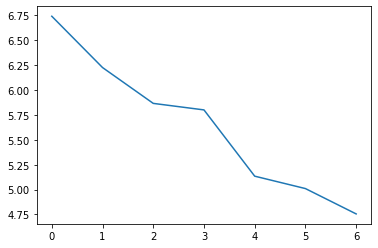

In [ ]:
plt.plot(Sigma)

#### Interpretando los tópicos


La siguiente función solo toma la matriz de VT y obtiene las 8 palabras más importantes en este topico. Si quieren pueden variar este parametro para ver más palabras e inspeccionar los tópicos. Esto es importante porque LSI es un método no supervisado, por lo tanto no sabemos a priori cuando un tópico es bueno o malo. El sentido debemos darselo nosotros:

In [ ]:
def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[-8:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
show_topics(VT)

['medalla querer ganar gustar comprar cerveza cruzcampo',
 'olimpia nikes siempre nuevo zapatilla camiseta adidas',
 'comprar nuevo conocer gustar aldub81stweeksary superstar cruzcampo',
 'bueno querer invitar beber arruinaunacitacon4palabras cerveza gustar',
 '10 terminar carrera milka ritmar correr acabo',
 'alfajor querer ganar carrefour comprar mercadona chocolate',
 'panga vender movistar mejor comprar bimbo carrefour']

Limitaciones en LSI:
 - LSI sufre de un problema llamado "Indeterminación del signo", que básicamente significa que el signo en la matríz VT y USigma dependen del algorimo que se utilizó para generarlos y de las condiciones iniciales (initial random state). En este contexto, que significa que un tópico esté relacionado con una palabra en un valor negativo?

### NMF: Non-negative Matrix Factorization

Motivación: En lugar de construir nuestros factores imponiendo la restricción de que sean ortogonales, la idea es de construirlos de tal forma que sean no-negativos.

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=7, random_state = 1234)

In [ ]:
W1 = nmf.fit_transform(vectors)
H1 = nmf.components_

En este caso, la matriz que nos interesa es H1

In [ ]:
H1.shape

(7, 6729)

#### Interpretando los tópicos

In [ ]:
show_topics(H1)

['novio comprar querer corona medalla cerveza ganar',
 'olimpia color nikes siempre nuevo zapatilla camiseta',
 'tenis napaacc cliente nuevo conocer aldub81stweeksary superstar',
 'mahou invitar querer beber arruinaunacitacon4palabras cerveza gustar',
 '50 10 terminar carrera ritmar correr acabo',
 'mcflurry necesito quiero querer alfajor ganar chocolate',
 'panga vender movistar mejor comprar bimbo carrefour']

### LDA: Latent Dirichlet Allocation

LDA es un método Bayesiano basado en la distribución de Dirichlet, la cual es una distribución sobre probabilidades en K categorias. LDA supone que los documentos que tenemos pertenecen a K categorias distintas cuya distribución es desconocida.

La distribución Dirichlet es una generalización de la distribución Beta en un espacio multidimensional. Así como la distribución beta es la distribución previa de la binomial, la distribución de Dirichlet es la distribución previa de la multinomial. 

$$ P(w\mid d) = P(d)\sum_c P(k\mid d)P(w\mid k) $$

*¿Notan alguna similitud con SVD?*

David Blei, Andrew Ng, Michael Jordan:  Latent Dirichlet Allocation [https://jmlr.org/papers/volume3/blei03a/blei03a.pdf]

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7)

In [ ]:
lda.fit(vectors)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [ ]:
for idx, topic in enumerate(lda.components_):
    print ("Topic ", idx, " ".join(vocab[i] for i in topic.argsort()[:-10 - 1:-1]))

Topic  0 cruzcampo milka heineken toyota gustar bimbo carrefour cerveza llevar arruinaunacitacon4palabras
Topic  1 adir adidas mercadona bimbo comprar heineken alcampo milka barato supermercado
Topic  2 querer heineken adidas mercadona ir movistar banco poder hacendar vez
Topic  3 galicia carrefour estrella movistar banco mercadona heineken soler sabadell bueno
Topic  4 movistar toyota heineken mercadona adidas favor suzuki hacer vender adir
Topic  5 heineken nikeplus acabo correr ritmar santander mejor bimbo mercadona cerveza
Topic  6 heineken mueble bankia adir montar encontrar vestir quien medalla carrefour


## Creando un pipeline de preprocesamiento de texto

A pesar de que los métodos anteriores son no supervisados, son de utilidad para el modelado de de problemas no supervisados como supervisados. Para llevar estos métodos a un entorno práctico normalmente se construyen flujos de procesamiento como el que se muestra más abajo. Estos flujos se los llama Pipeline:

<img src='https://github.com/santiagxf/M72109/blob/master/NLP/Docs/atap_0406.png?raw=1' />

A modo de ejemplo, vamos a utilizar la API de Scikit-Learn para generar cada uno de estos pasos y así construir un modelo que resuelva un problema de negocio de punta a punta.

**¿Que es lo que vamos a hacer?**
Intentaremos construir un pipeline de machine learning donde como entrada recibamos texto, ejecutemos todos los pasos que vimos en este notebook incluyendo:
 - Eliminación de stopwords
 - Tokenización
 - Stemming y Lemmatization
 - Procesamiento especico del tema
 - Creación de features utilizando algun metodo de reducción de dimensionalidad, SVD, LSI, LDA

, para luego utilizar estas features para entrenar un modelo que nos permita predecir alguna propiedad interesante del set de datos. En este caso en particular, donde estamos viendo tweets, algunos casos interesantes podrían ser:
 - Predecir el sector al que pertenece el tweet: Alimentación, Bebidas, etc.
 - Predecir el paso en el Marketing Funel al que pertece

### Creando un paso de Pipeline para procesamiento de texto

El paso más complejo que tenemos para crear es quizas el preprocesamiento del texto. Esto lo podemos encapsular en un modulo de Scikit-Learn. Esta libreria tiene 2 tipos de modulos:
 - Transformers
 - Estimators

Los transformers toman un set de features y devuelven otro set de features, por eso es que reciben el nombre de "trasformers", porque basicamente transforman vectores. Los estimators, por el contrario, reciben un set de features y producen un podelo que aproxima, o estima, una variable target. Por este motivo, estos modulos reciben el nombre de "estimators".

¿Qué modulo les parece que va a implementar nuestro proceso de "preprocesamiento" de texto?

In [ ]:
import unidecode
import spacy
import es_core_news_sm as spa
import re
import sklearn
from nltk import stem
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer

class TextNormalizer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, language='spanish'):
        self.parser = spa.load() # Cargamos el parser en español
        self.tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True) # Creamos un tokenizer
        self.stemmer = stem.SnowballStemmer(language=language) # Creamos un steammer
        self.lemmatizer = lambda word : " ".join([token.lemma_ for token in self.parser(word)]) # Creamos un lemmatizer
        self.stopwords = set(stopwords.words(language)) # Instanciamos las stopwords en español
        self.urls_regex = re.compile('http\S+') # Usamos una expresion regular para encontrar las URLs
    
    def process_text(self, text):
        tokens = self.tokenizer.tokenize(text)
        tokens = [token for token in tokens if not re.match(urls_regex, token)]
        tokens = [token for token in tokens if len(token) > 4]
        tokens = [token for token in tokens if token not in self.stopwords]
        tokens = [unidecode.unidecode(token) for token in tokens] # Quitamos acentos
        tokens = [self.lemmatizer(token) for token in tokens]
        return tokens
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for doc in X:
          yield ' '.join(self.process_text(text=doc))

Instanciamos nuestro preprocesamiento de texto

In [ ]:
normalizer = TextNormalizer()

Podemos ver como funciona nuestro modulo de preprocesamiento de texto al llamarlo con la función transform:

In [ ]:
tweet = tweets['TEXTO'][5]
print(tweet)

. @PoliciadeBurgos @PCivilBurgos @Aytoburgos Mismo peligro c/ Rio Viejo junto Mercadona Villimar


In [ ]:
list(normalizer.transform([tweet]))

['Mismo peligrar Viejo juntar Mercadona Villimar']

*Nota: Usamso list() solamente porque transform es una operación de tipo lazy. Esto significa que no se ejecuta hasta que enumeramos los resultados*

### Construyendo nuestro pipeline

Importamos algunas librerias que necesitaremos

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

Instanciamos nuestro vectorizador, en este caso usando el método TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, sublinear_tf=True, norm='l2')

Instanciamos nuestro generador de features, que en este caso son los tópicos que LDA genere

In [ ]:
featurizer = LatentDirichletAllocation(n_components=7)

Instanciamos nuestro clasificador que utilizará las features generadas hasta este momento

In [ ]:
estimator = LogisticRegression(max_iter=10000, multi_class='multinomial')

Creamos un pipeline que ejecute todos los pasos en secuencia

In [ ]:
pipeline = Pipeline(steps=[('normalizer', normalizer), 
                           ('vectorizer', vectorizer),
                           ('featurizer', featurizer),
                           ('estimator', estimator)])

### Entrenando nuestro pipeline

En este caso intentaremos predecir el sector al que pertenece un tweet en particular. Para ello, como en todo proceso de machine learning separaremos nuestros datos en training y testing, para poder evaluar los resultados:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets['TEXTO'], tweets['SECTOR'], test_size=0.33, stratify=tweets['SECTOR'])

El método fit intrenará nuestro modelo de punta a punta. Tomará unos minutos

In [ ]:
model = pipeline.fit(X=X_train, y=y_train)

Es hora de ver que tan bien le fué a nuestro modelo en esta tarea

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

ALIMENTACION       0.00      0.00      0.00       110
  AUTOMOCION       0.00      0.00      0.00       148
       BANCA       0.28      0.11      0.15       198
     BEBIDAS       0.25      0.28      0.26       223
    DEPORTES       0.27      0.30      0.28       216
      RETAIL       0.21      0.52      0.29       268
       TELCO       0.00      0.00      0.00        79

    accuracy                           0.23      1242
   macro avg       0.14      0.17      0.14      1242
weighted avg       0.18      0.23      0.18      1242



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


¿Les parece que estás métricas son buenas? ¿Se les ocurre como mejorarlo? Algunas ideas:
 - ¿Quien funcionará mejor? ¿Stemmer o Lemmatization?
 - ¿Qué será mejor hacer con los hashtags? ¿Quitarlos?
 - ¿Que cantidad de factores latentes funcionará mejor? ¿7, 10, 200, 300?
 - ¿Es Logistic Regression el mejor clasificador que podemos probar? ¿Si subimos la cantidad de tópicos que me sería mejor utilizar?